<h2 style='color:blue' align='center'>Sports Celebrity Image Classification<h2>

In [4]:
%matplotlib inline
import numpy as np
import cv2,pywt,os,pickle
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

### Wavelet transform

In [5]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [6]:
path_to_cr_data = "./dataset/"
cr_img_dirs = []
for entry in os.scandir(path_to_cr_data):
    if entry.is_dir():
        cr_img_dirs.append(entry.path)
cr_img_dirs

['./dataset/Tim Cook',
 './dataset/Satya Nadella',
 './dataset/Elon Musk',
 './dataset/Sundar Pichai',
 './dataset/susan wojcicki',
 './dataset/safra catz',
 './dataset/Mark Zuckerberg']

In [7]:
celebrity_file_names_dict = {}
alias_dict = {}
count = 0
for img_dir in cr_img_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    alias_dict[celebrity_name] = count
    count = count + 1
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'Tim Cook': ['./dataset/Tim Cook/Tim Cook5.png',
  './dataset/Tim Cook/Tim Cook24.png',
  './dataset/Tim Cook/Tim Cook15.png',
  './dataset/Tim Cook/Tim Cook23.png',
  './dataset/Tim Cook/Tim Cook13.png',
  './dataset/Tim Cook/Tim Cook7.png',
  './dataset/Tim Cook/Tim Cook14.png',
  './dataset/Tim Cook/Tim Cook16.png',
  './dataset/Tim Cook/Tim Cook17.png',
  './dataset/Tim Cook/Tim Cook26.png',
  './dataset/Tim Cook/Tim Cook4.png',
  './dataset/Tim Cook/Tim Cook18.png',
  './dataset/Tim Cook/Tim Cook19.png',
  './dataset/Tim Cook/Tim Cook20.png',
  './dataset/Tim Cook/Tim Cook2.png',
  './dataset/Tim Cook/Tim Cook10.png',
  './dataset/Tim Cook/Tim Cook28.png',
  './dataset/Tim Cook/Tim Cook3.png',
  './dataset/Tim Cook/Tim Cook25.png',
  './dataset/Tim Cook/Tim Cook22.png',
  './dataset/Tim Cook/Tim Cook8.png',
  './dataset/Tim Cook/Tim Cook6.png',
  './dataset/Tim Cook/Tim Cook9.png',
  './dataset/Tim Cook/Tim Cook1.png'],
 'Satya Nadella': ['./dataset/Satya Nadella/Satya Nadella9.p

In [8]:
alias_dict

{'Tim Cook': 0,
 'Satya Nadella': 1,
 'Elon Musk': 2,
 'Sundar Pichai': 3,
 'susan wojcicki': 4,
 'safra catz': 5,
 'Mark Zuckerberg': 6}

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [9]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(alias_dict[celebrity_name])     

In [11]:
print(f"{len(X[0])} == {32*32*3 + 32*32}    {len(X)}")

4096 == 4096    355


Alias labels are stored in y

In [12]:
print(f"{y}\n{len(y)}")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [13]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(355, 4096)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7323943661971831

In [19]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       1.00      0.33      0.50         6
           2       0.80      0.80      0.80        10
           3       0.75      0.86      0.80         7
           4       1.00      0.78      0.88        18
           5       1.00      0.86      0.92         7
           6       0.52      1.00      0.68        16

    accuracy                           0.73        71
   macro avg       0.72      0.66      0.65        71
weighted avg       0.74      0.73      0.70        71



/home/brp/Documents/IdentifyTheCEO/ITC_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brp/Documents/IdentifyTheCEO/ITC_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brp/Documents/IdentifyTheCEO/ITC_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [20]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [0.01, 0.1, 1, 10, 100, 1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [100*i for i in range(1,6)]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1, 10]
        }
    }
}

In [21]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.820363,"{'svc__C': 0.01, 'svc__kernel': 'linear'}"
1,random_forest,0.683083,{'randomforestclassifier__n_estimators': 300}
2,logistic_regression,0.823872,{'logisticregression__C': 10}


In [22]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=0.01, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=300))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=10, solver='liblinear'))])}

<h4 style='color:red'>Though svm, logistic regression gave almost similar best scores, I am choosing to go with svm because logistic regression has the risk of overfitting and svm is generally used for image classification purposes.</h4>

In [29]:
best_estimators['svm'].score(X_test,y_test)

0.8169014084507042

In [30]:
best_clf = best_estimators['svm']

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 4,  3,  0,  0,  0,  0,  0],
       [ 0,  4,  0,  0,  1,  0,  1],
       [ 0,  0,  8,  0,  0,  0,  2],
       [ 0,  0,  0,  6,  1,  0,  0],
       [ 0,  0,  1,  0, 15,  0,  2],
       [ 0,  1,  0,  0,  0,  6,  0],
       [ 0,  0,  0,  0,  1,  0, 15]])

Text(69.0, 0.5, 'Truth')

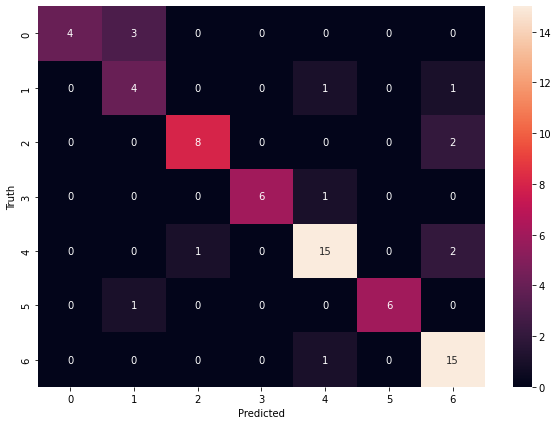

In [32]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Save the trained model

In [35]:
import pickle
# Save the model as a pickle in a file 
with open('saved_model', 'wb') as files:
    pickle.dump(best_clf, files)

In [34]:
with open('saved_model' , 'rb') as fp:
    clf = pickle.load(fp)
clf.score(X_test, y_test)

0.8169014084507042

### Save class dictionary

In [36]:
import json
with open("alias_dictionary.json","w") as f:
    f.write(json.dumps(alias_dict))